## Part 3: Training Neural Networks

In this notebook, we are going to learn how to train a very simple Neural Netowrks. We will go over the topics below: 

* [Background Knowledge Fresh up](#background)
* [Backpropagation](#Backpropagation)
* [Augograd](#autograd)
* [Build the Network](#buildnetwork)
* [Train the Network](#trainnetwork)
* [Evaluate](#evaluate)

<a id = 'background'></a>
### Background Knowledge Fresh Up
The network we built in the previous part isn't so smart, it doesn't know anything about our handwritten digits. Neural networks with non-linear activations work like universal function approximators. There is some function that maps your input to the output. For example, images of handwritten digits to class probabilities. The power of neural networks is that we can train them to approximate this function, and basically any function given enough data and compute time.

At first the network is naive, it doesn't know the function mapping the inputs to the outputs. We train the network by showing it examples of real data, then adjusting the network parameters such that it approximates this function.

To find these parameters, we need to know how poorly the network is predicting the real outputs. For this we calculate a **loss function** (also called the cost), a measure of our prediction error. For example, the mean squared loss is often used in regression and binary classification problems

$$
\ell = \frac{1}{2n}\sum_i^n{\left(y_i - \hat{y}_i\right)^2}
$$

where $n$ is the number of training examples, $y_i$ are the true labels, and $\hat{y}_i$ are the predicted labels.

By minimizing this loss with respect to the network parameters, we can find configurations where the loss is at a minimum and the network is able to predict the correct labels with high accuracy. We find this minimum using a process called **gradient descent**. The gradient is the slope of the loss function and points in the direction of fastest change. To get to the minimum in the least amount of time, we then want to follow the gradient (downwards). You can think of this like descending a mountain by following the steepest slope to the base.

<a id = 'Backpropagation'></a>
## Backpropagation

For single layer networks, gradient descent is simple to implement. However, it's more complicated for deeper, multilayer neural networks like the one we've built. Complicated enough that it took about 30 years before researchers figured out how to train multilayer networks, although it's straightforward once you learn about it. 

This is done through **backpropagation** which is really just an application of the chain rule from calculus. It's easiest to understand if we convert a two layer network into a graph representation.

In the forward pass through the network, our data and operations go from right to left here. To train the weights with gradient descent, we propagate the gradient of the cost backwards through the network. Mathematically, this is really just calculating the gradient of the loss with respect to the weights using the chain rule.

$$
\frac{\partial \ell}{\partial w_1} = \frac{\partial l_1}{\partial w_1} \frac{\partial s}{\partial l_1} \frac{\partial l_2}{\partial s} \frac{\partial \ell}{\partial l_2}
$$

We update our weights using this gradient with some learning rate $\alpha$. 

$$
w^\prime = w - \alpha \frac{\partial \ell}{\partial w}
$$

The learning rate is set such that the weight update steps are small enough that the iterative method settles in a minimum.

The first thing we need to do for training is define our loss function. In PyTorch, you'll usually see this as `criterion`. Here we're using softmax output, so we want to use `criterion = nn.CrossEntropyLoss()` as our loss. Later when training, you use `loss = criterion(output, targets)` to calculate the actual loss.

We also need to define the optimizer we're using, SGD or Adam, or something along those lines. Here I'll just use SGD with `torch.optim.SGD`, passing in the network parameters and the learning rate.

<a id = 'autograd'></a>
## Autograd

Torch provides a module, `autograd`, for automatically calculating the gradient of tensors. It does this by keeping track of operations performed on tensors. To make sure PyTorch keeps track of operations on a tensor and calculates the gradients, you need to set `requires_grad` on a tensor. You can do this at creation with the `requires_grad` keyword, or at any time with `x.requires_grad_(True)`.

You can turn off gradients for a block of code with the `torch.no_grad()` content:
```python
x = torch.zeros(1, requires_grad=True)
>>> with torch.no_grad():
...     y = x * 2
>>> y.requires_grad
False
```

Also, you can turn on or off gradients altogether with `torch.set_grad_enabled(True|False)`.

The gradients are computed with respect to some variable `z` with `z.backward()`. This does a backward pass through the operations that created `z`.

The following codes illustrate the autograd module.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from collections import OrderedDict

import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import helper

In [2]:
# create a random matrix
x = torch.randn(2, 2,requires_grad=True)
print(x)

tensor([[ 3.7610,  0.7640],
        [ 0.5399,  0.9701]])


In [3]:
y = x **2
print(y)

tensor([[ 14.1454,   0.5837],
        [  0.2915,   0.9410]])


Below we can see the operation that created `y`, a power operation `PowBackward0`.

In [4]:
## grad_fn shows the function that generated this variable
print(y.grad_fn)

The autgrad module keeps track of these operations and knows how to calculate the gradient for each one. In this way, it's able to calculate the gradients for a chain of operations, with respect to any one tensor. Let's reduce the tensor `y` to a scalar value, the mean.

In [5]:
z = y.mean()
print(z)

tensor(3.9904)


In [6]:
# You can check the gradients for x and y but they are empty currently because we haven't calculate the backword yet
print(x.grad)
print(y.grad)

None
None


To calculate the gradients, you need to run the `.backward` method on a Variable, `z` for example. This will calculate the gradient for `z` with respect to `x`

$$
\frac{\partial z}{\partial x} = \frac{\partial}{\partial x}\left[\frac{1}{n}\sum_i^n x_i^2\right] = \frac{x}{2}
$$

Note: we have 4 elements so n = 4. X^2 derivative with respect to X is 2X

In [7]:
# backprop z
z.backward()

# check the gradient
print(x.grad)

# see if x.grad matches with x/2
print(x/2)

print("If all 1, that's means x.grad = x/2.\n ", x.grad == (x/2))

tensor([[ 1.8805,  0.3820],
        [ 0.2700,  0.4850]])
tensor([[ 1.8805,  0.3820],
        [ 0.2700,  0.4850]])
If all 1, that's means x.grad = x/2.
  tensor([[ 1,  1],
        [ 1,  1]], dtype=torch.uint8)


These gradients calculations are particularly useful for neural networks. For training we need the gradients of the weights with respect to the cost. With PyTorch, we run data forward through the network to calculate the cost, then, go backwards to calculate the gradients with respect to the cost. Once we have the gradients we can make a gradient descent step.

<a id = 'buildnetwork'></a>
## Start training the network

Get the data and define the network

The same as we saw in part 2, we'll load the MNIST dataset and define our network.

In [8]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

# Download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

I'll build a network with `nn.Sequential` here. Only difference from the last part is I'm not actually using softmax on the output, but instead just using the raw output from the last layer. This is because the output from softmax is a probability distribution. Often, the output will have values really close to zero or really close to one. Due to [inaccuracies with representing numbers as floating points](https://docs.python.org/3/tutorial/floatingpoint.html), computations with a softmax output can lose accuracy and become unstable. To get around this, we'll use the raw output, called the **logits**, to calculate the loss.

In [10]:
# define hyperparameter for our model 
input_size = 784
hidden_layer = [128, 64]
output_size = 10

# build the feed-forward model
model = nn.Sequential(OrderedDict([
                     ('fc1', nn.Linear(input_size, hidden_layer[0])),
                     ('relu1', nn.ReLU()),
                     ('fc2', nn.Linear(hidden_layer[0], hidden_layer[1])),
                     ('logits', nn.Linear(hidden_layer[1], output_size))]))

<a id = 'trainnetwork'></a>
## Training the network!

The first thing we need to do for training is define our loss function. In PyTorch, you'll usually see this as `criterion`. Here we're using softmax output, so we want to use `criterion = nn.CrossEntropyLoss()` as our loss. Later when training, you use `loss = criterion(output, targets)` to calculate the actual loss.

We also need to define the optimizer we're using, SGD or Adam, or something along those lines. Here I'll just use SGD with `torch.optim.SGD`, passing in the network parameters and the learning rate.

In [11]:
# see the model parameters to make sure we create the neural network properly. 
model.parameters

<bound method Module.parameters of Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (logits): Linear(in_features=64, out_features=10, bias=True)
)>

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

First, let's consider just one learning step before looping through all the data. The general process with PyTorch:

* Make a forward pass through the network to get the logits 
* Use the logits to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights

Below I'll go through one training step and print out the weights and gradients so you can see how it changes.

In [13]:
# try one image example
images, labels = next(iter(trainloader))

In [14]:
# check the images size
images.size()

torch.Size([64, 1, 28, 28])

In [15]:
print('Initial weights - ', model.fc1.weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights

# step 1: Make a forward pass through the network to get the logits
output = model.forward(images)

# step 2: Use the logits to calculate the loss
loss = criterion(output, labels)

# step3: Perform a backward pass through the network with loss.backward() to calculate the gradients
loss.backward() # calculate the gradient

# Now we can see the gradient
print('Gradient -', model.fc1.weight.grad)

# step 4: Take a step with the optimizer to update the weights
optimizer.step()


Initial weights -  Parameter containing:
tensor([[ 2.4935e-02, -2.1995e-02, -1.3368e-02,  ...,  2.3797e-02,
         -1.7565e-02, -2.4601e-02],
        [-3.0496e-02, -2.0130e-02, -3.2776e-02,  ...,  2.3805e-02,
         -2.8766e-02,  1.8333e-02],
        [-4.6981e-04,  2.9383e-02,  3.4511e-02,  ..., -1.9006e-02,
         -2.4319e-03, -2.6045e-02],
        ...,
        [ 8.4056e-04, -1.0059e-02, -9.7096e-03,  ..., -9.7570e-04,
         -1.5515e-03, -2.2610e-02],
        [ 3.5283e-02,  3.0022e-02, -6.5701e-04,  ..., -2.7307e-02,
          2.9713e-03,  2.6113e-03],
        [-2.1180e-02, -6.6372e-03, -1.0936e-02,  ...,  2.2196e-02,
          1.0461e-02, -2.9415e-02]])
Gradient - tensor(1.00000e-02 *
       [[ 0.0465,  0.0465,  0.0465,  ...,  0.0465,  0.0465,  0.0465],
        [ 0.3749,  0.3749,  0.3749,  ...,  0.3749,  0.3749,  0.3749],
        [-0.0150, -0.0150, -0.0150,  ..., -0.0150, -0.0150, -0.0150],
        ...,
        [ 0.1196,  0.1196,  0.1196,  ...,  0.1196,  0.1196,  0.1196],
  

In [16]:
loss.item()

2.3179285526275635

In [17]:
# see how the weights are updated. 
print('Updated weights - ', model.fc1.weight)

Updated weights -  Parameter containing:
tensor([[ 2.4934e-02, -2.1996e-02, -1.3368e-02,  ...,  2.3796e-02,
         -1.7566e-02, -2.4601e-02],
        [-3.0500e-02, -2.0134e-02, -3.2780e-02,  ...,  2.3801e-02,
         -2.8769e-02,  1.8330e-02],
        [-4.6966e-04,  2.9383e-02,  3.4512e-02,  ..., -1.9006e-02,
         -2.4317e-03, -2.6044e-02],
        ...,
        [ 8.3937e-04, -1.0061e-02, -9.7108e-03,  ..., -9.7689e-04,
         -1.5527e-03, -2.2611e-02],
        [ 3.5282e-02,  3.0021e-02, -6.5788e-04,  ..., -2.7308e-02,
          2.9704e-03,  2.6104e-03],
        [-2.1181e-02, -6.6380e-03, -1.0936e-02,  ...,  2.2195e-02,
          1.0460e-02, -2.9416e-02]])


## Training for real

Now we'll put this algorithm into a loop so we can go through all the images. This is fairly straightforward. We'll loop through the mini-batches in our dataset, pass the data through the network to calculate the losses, get the gradients, then run the optimizer.

In [18]:
optimizer = optim.SGD(model.parameters(), lr=0.003)

In [19]:
epochs = 3 # epochs is the pass to the dataset. Here we pass the dataset 3 times
print_every = 40 # print out some results for every 40 run
steps = 0

for e in range(epochs):
    running_loss = 0 # this is to print out the loss of the train for each trail. We should expect this to drop since 
                     # as our network learns, our prediction becomes better and loss is smaller. 
    
    for images, labels in iter(trainloader):
        steps += 1 # record # of steps we train
        
        # Flatten MNIST images into a 784 long vector
        images.resize_(images.shape[0], 784)
        
        # Clear the gradients, do this because gradients are accumulated
        optimizer.zero_grad()
        
        # do the forward, backward, then update the weighs
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # print out the results for every 40 trails
        if steps % print_every == 0:
            print("Epoch: {}/{}...".format(e+1,epochs),
                  "Loss: {:.4f}".format(running_loss/print_every))
            
            running_loss = 0

Epoch: 1/3... Loss: 2.2926
Epoch: 1/3... Loss: 2.2545
Epoch: 1/3... Loss: 2.2137
Epoch: 1/3... Loss: 2.1733
Epoch: 1/3... Loss: 2.1325
Epoch: 1/3... Loss: 2.0782
Epoch: 1/3... Loss: 2.0403
Epoch: 1/3... Loss: 1.9860
Epoch: 1/3... Loss: 1.9141
Epoch: 1/3... Loss: 1.8354
Epoch: 1/3... Loss: 1.7986
Epoch: 1/3... Loss: 1.7226
Epoch: 1/3... Loss: 1.6504
Epoch: 1/3... Loss: 1.5877
Epoch: 1/3... Loss: 1.5039
Epoch: 1/3... Loss: 1.4283
Epoch: 1/3... Loss: 1.3734
Epoch: 1/3... Loss: 1.2967
Epoch: 1/3... Loss: 1.2163
Epoch: 1/3... Loss: 1.1824
Epoch: 1/3... Loss: 1.1025
Epoch: 1/3... Loss: 1.0678
Epoch: 1/3... Loss: 1.0060
Epoch: 2/3... Loss: 0.5281
Epoch: 2/3... Loss: 0.9182
Epoch: 2/3... Loss: 0.8935
Epoch: 2/3... Loss: 0.8719
Epoch: 2/3... Loss: 0.8004
Epoch: 2/3... Loss: 0.7816
Epoch: 2/3... Loss: 0.7784
Epoch: 2/3... Loss: 0.7698
Epoch: 2/3... Loss: 0.6979
Epoch: 2/3... Loss: 0.7320
Epoch: 2/3... Loss: 0.6996
Epoch: 2/3... Loss: 0.6636
Epoch: 2/3... Loss: 0.6747
Epoch: 2/3... Loss: 0.6473
E

<a id = 'evaluate'></a>
## Evaluate the Model

With the network trained, we can check out it's predictions.

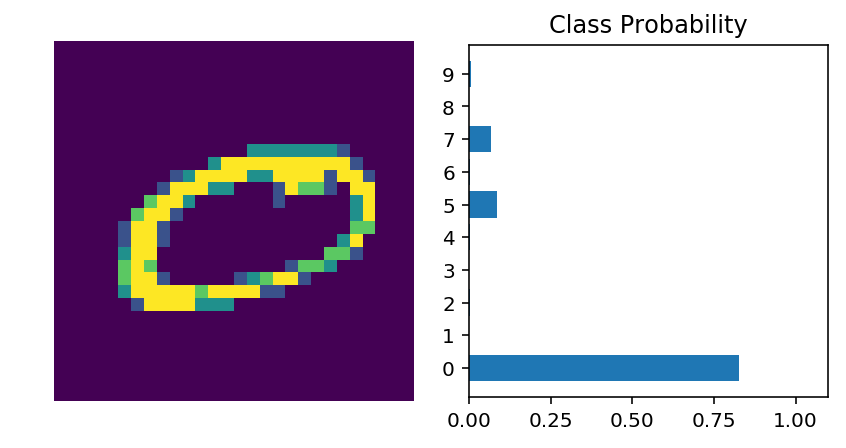

In [20]:
images, labesl = next(iter(trainloader))

img = images[0].view(1,784)

# Turn off gradients to speed up this part. Put the image to the model for prediction
with torch.no_grad():
    logits = model.forward(img)
    
# Output of the network are logits, need to take softmax for probabilities
ps = F.softmax(logits, dim=1)
helper.view_classify(img.view(1, 28, 28), ps)

The result looks farily good! It does predict a high probability of image = 0.